In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import sklearn

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import data_utility
import times
import segmentation
import preprocess
import autoencoder
import visualizer
import kaggle_data_utility
import annotation_utility
import interactive_plot

In [3]:
raw_annotations = pd.read_csv('full_updated_anns_annotTbl_cleaned.csv')
ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# ids = list(np.unique(raw_annotations['HUP_ID']))
ids

['HUP047',
 'HUP084',
 'HUP096',
 'HUP109',
 'HUP121',
 'HUP129',
 'HUP131',
 'HUP137',
 'HUP147',
 'HUP153',
 'HUP156',
 'HUP159',
 'HUP182',
 'HUP197',
 'HUP199',
 'HUP205',
 'RNS026',
 'RNS029']

In [4]:
data_import = data_utility.read_files(path = 'data/rns_data', path_data =  'rns_raw_cache', patientIDs=ids,
                                      verbose=True)  # Import data with annotation

100%|██████████| 18/18 [00:11<00:00,  1.52it/s]


In [5]:
annotations = annotation_utility.read_annotation(annotation_path = 'full_updated_anns_annotTbl_cleaned.csv',data = data_import,n_class =3)

In [6]:
annot = annotations.annotations
annot_nonseizure = annot[annot['Class_Code']==0]
annot_seizure = annot[annot['Class_Code']==1]
patient_list = list(np.unique(annot['Patient_ID']))
# patient_list = ['RNS026', 'HUP159', 'HUP129', 'HUP096']
clip_dict = {}
for p in patient_list:
    seizure_start_index = np.array([])
    seizure_end_index = np.array([])
    nonseizure_start_index = np.array([])
    nonseizure_end_index = np.array([])
    start_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_Start_Index']
    end_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_End_Index']
    annot_start_list = annot_seizure[annot_seizure['Patient_ID'] == p]['Annotation_Start_Index']
    annot_end_list = annot_seizure[annot_seizure['Patient_ID'] == p]['Annotation_End_Index']
    for i, slel in enumerate(zip(annot_start_list, annot_end_list)):
        sl = slel[0]
        el = slel[1]
        annot_array = np.vstack((sl, el))
        test = start_index.iloc[i]
        seizure_start_index = np.hstack((seizure_start_index, annot_array[0, :]))
        seizure_end_index = np.hstack((seizure_end_index, annot_array[1, :]))

        nonseizure_start_index = np.hstack((nonseizure_start_index, start_index.iloc[i]))
        nonseizure_end_index = np.hstack((nonseizure_end_index, annot_array[0, 0]))

        nonseizure_start_index = np.hstack((nonseizure_start_index, annot_array[1, -1]))
        nonseizure_end_index = np.hstack((nonseizure_end_index, end_index.iloc[i]))
        if annot_array.shape[1] > 1:
            test1 = annot_array[0, 1:]
            test2 = annot_array[1, :-1]
            nonseizure_start_index = np.hstack((nonseizure_start_index, annot_array[0, 1:]))
            nonseizure_end_index = np.hstack((nonseizure_end_index, annot_array[1, :-1]))

    nonseizure_valid = np.where(nonseizure_end_index-nonseizure_start_index > 500)
    seizure_valid = np.where(seizure_end_index-seizure_start_index > 500)

    nonseizure_ind_arr = np.vstack((nonseizure_start_index[nonseizure_valid], nonseizure_end_index[nonseizure_valid])).astype(int)
    start_index = annot_nonseizure[annot_nonseizure['Patient_ID']==p]['Episode_Start_Index']
    end_index = annot_nonseizure[annot_nonseizure['Patient_ID']==p]['Episode_End_Index']

    print(np.vstack((seizure_start_index[seizure_valid], seizure_end_index[seizure_valid])).astype(int).shape)
    valid = np.where(end_index-start_index > 500)
    nonseizure_ind_arr_eps = np.vstack((start_index.iloc[valid],end_index.iloc[valid])).astype(int)
    
    if len(valid[0]) and len(seizure_valid[0])>0:
        nonseizure_clip_temp = np.hstack((nonseizure_ind_arr,nonseizure_ind_arr_eps))
        seizure_clip_temp = np.vstack((seizure_start_index[seizure_valid], seizure_end_index[seizure_valid])).astype(int)

        nonseizure_clip_label = np.zeros(nonseizure_clip_temp.shape[1]).astype(int)
        seizure_clip_label = np.ones(seizure_clip_temp.shape[1]).astype(int)

        seizure_clip = np.vstack((seizure_clip_temp,seizure_clip_label))
        non_seizure_clip = np.vstack((nonseizure_clip_temp,nonseizure_clip_label))

        clip_dict[p] = np.hstack((seizure_clip, non_seizure_clip))



(2, 25)
(2, 20)
(2, 59)
(2, 39)
(2, 4)
(2, 60)
(2, 21)
(2, 41)
(2, 44)
(2, 0)
(2, 71)
(2, 99)
(2, 24)
(2, 0)
(2, 40)
(2, 0)
(2, 73)
(2, 51)


In [7]:
annot

,Dataset,Annotation_Catalog_Index,Patient_ID,Alias_ID,Episode_Start_Timestamp,Episode_End_Timestamp,Episode_Start_UTC_Time,Episode_End_UTC_Time,Episode_Index,Episode_Start_Index,Episode_End_Index,Annotation_Start_Timestamp,Annotation_End_Timestamp,Annotation_Start_UTC_Time,Annotation_End_UTC_Time,Annotation_Start_Index,Annotation_End_Index,Type_Description,Class_Code,Annotation_Channel,Channel_Code,Binary_Channel_Code
0,RNS_Annotations_JimGugger,0,HUP096,RNS_1_JiGu,1427397884964000,1427397975128000,2015-03-26 19:24:44.964,2015-03-26 19:26:15.128,5,138107,160647,[],[],[],[],[],[],no,0,[],[],[]
1,RNS_Annotations_JimGugger,1,HUP096,RNS_1_JiGu,1427742903476000,1427742993628000,2015-03-30 19:15:03.476,2015-03-30 19:16:33.628,10,250781,273318,[],[],[],[],[],[],no,0,[],[],[]
2,RNS_Annotations_JimGugger,2,HUP096,RNS_1_JiGu,1427919210984000,1427919301120000,2015-04-01 20:13:30.984,2015-04-01 20:15:01.120,21,498694,521227,[],[],[],[],[],[],no,0,[],[],[]
3,RNS_Annotations_JimGugger,3,HUP096,RNS_1_JiGu,1427963083488000,1427963173624000,2015-04-02 08:24:43.488,2015-04-02 08:26:13.624,22,521228,543761,[],[],[],[],[],[],no,0,[],[],[]
4,RNS_Annotations_JimGugger,4,HUP096,RNS_1_JiGu,1428304634480000,1428304724616000,2015-04-06 07:17:14.480,2015-04-06 07:18:44.616,34,791679,814212,[],[],[],[],[],[],no,0,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,RNS_Annotations_ErinConrad,3924,HUP199,RNS_3_ErCo,1651096512496000,1651096602516000,2022-04-27 21:55:12.496,2022-04-27 21:56:42.516,2984,66967478,66989982,[1651096537416000],[1651096592443000],[2022-04-27 21:55:37.416000],[2022-04-27 21:56:32.443000],[66973708],[66987463],yes,1,"[1,2]",[1110],[]
3925,RNS_Annotations_ErinConrad,3925,HUP199,RNS_3_ErCo,1652403775468000,1652403865392000,2022-05-13 01:02:55.468,2022-05-13 01:04:25.392,3043,68292954,68315434,[1652403775575000],[1652403851536000],[2022-05-13 01:02:55.575000],[2022-05-13 01:04:11.536000],[68292981],[68311969],yes,1,"[1,2]",[1110],[]
3926,RNS_Annotations_ErinConrad,3926,HUP199,RNS_3_ErCo,1652901348068000,1652901438044000,2022-05-18 19:15:48.068,2022-05-18 19:17:18.044,3065,68775838,68798331,[1652901376959000],[1652901437752000],[2022-05-18 19:16:16.959000],[2022-05-18 19:17:17.752000],[68783060],[68798257],yes,1,"[1,2]",[1110],[]
3927,RNS_Annotations_ErinConrad,3927,HUP199,RNS_3_ErCo,1656740710564000,1656740800640000,2022-07-02 05:45:10.564,2022-07-02 05:46:40.640,3213,72094667,72117185,[],[],[],[],[],[],no,0,[],[],[]


In [8]:
clip_dict

{'HUP047': array([[  189179, 13520388, 17429345, 18075435, 20548452, 21378458,
         27737883, 29987658, 30595747, 31655980, 33868563, 36111633,
         37438894, 39243225, 41194309, 42051016, 42253773, 45192229,
         48939023, 53043952, 57054146, 57530857, 58232089, 60717298,
         60784951,   180296,   193764, 13513695, 13528534, 17420575,
         17434858, 18066511, 18082506, 20539603, 20553802, 21368763,
         21382271, 27728466, 27743860, 29977900, 29993058, 30586253,
         30600731, 31648252, 31663360, 33858851, 33874961, 36102833,
         36118775, 37428648, 37443716, 39233740, 39247691, 41185051,
         41200297, 42041175, 42056632, 42243997, 42257592, 45181271,
         45196517, 48932455, 48947309, 53033722, 53048272, 57044111,
         57058500, 57523527, 57537023, 58221940, 58236150, 60707667,
         60723124, 60775207, 60789871,  2674246,  3159938,  4047327,
          4413657,  5217501,  6710271,  7025634,  7508985,  7541468,
          7556712,  8443

In [9]:
window_len = 1
stride = 1
concat_n = 4
for id in tqdm(clip_dict.keys()):
    data_import[id].set_window_parameter(window_length=window_len, window_displacement=stride)
    data_import[id].set_concatenation_parameter(concatenate_window_n=concat_n)
    window_indices,_ = data_import[id].get_windowed_data(clip_dict[id][0],clip_dict[id][1])
    index_table = [len(window_indices[i]) for i in range(len(window_indices))]
    import_label = np.array([])
    for i, ind in enumerate(window_indices):
        import_label = np.hstack((import_label,np.repeat(clip_dict[id][2][i],len(ind))))
    data_import[id].normalize_windowed_data()
    _, concatenated_data = data_import[id].get_concatenated_data(data_import[id].windowed_data, arrange='channel_stack')
    assert import_label.shape[0] == concatenated_data.shape[0]
    np.save('rns_test_cache/'+ id +'.npy',{'data':concatenated_data, 'label': import_label,'index':index_table})

100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


In [10]:
# unlabeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=False, transform=True,astensor = False)
# train_set_size = int(unlabeled_dataset.length * 0.8)
# valid_set_size = unlabeled_dataset.length - train_set_size
# train_set, test_set = torch.utils.data.random_split(unlabeled_dataset, [train_set_size, valid_set_size])

In [11]:
class RNS_Downstream(Dataset):
    def __init__(self, file_names, transform=True, astensor=True):
        self.file_names = file_names
        self.transform = transform

        file_name_temp = self.file_names[0]
        cache = np.load('rns_test_cache/' + file_name_temp, allow_pickle=True)
        temp_file = cache.item().get('data')

        self.data = np.empty((0, temp_file.shape[1], temp_file.shape[2]))
        self.label = np.array([])
        print(self.data.shape)

        for name in tqdm(self.file_names):
            cache = np.load('rns_test_cache/' + name, allow_pickle=True)
            data = cache.item().get('data')
            label = cache.item().get('label')
            self.data = np.vstack((self.data, data))
            self.label = np.hstack((self.label, label))

        print('data loaded')

        self.label = self.label[np.newaxis].T

        self.length = len(self.data)

        if astensor:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
                T.ToTensor()
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
        else:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            ])


    def __len__(self):
        return self.length


    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]

        if self.transform:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.augmentation(data)

        else:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            # np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.totensor(data)

        return data, torch.from_numpy(label).to(dtype=torch.long), None

In [12]:
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset, SwaVCollateFunction
from lightly.loss import SwaVLoss
from lightly.loss.memory_bank import MemoryBankModule
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes


class SwaV(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(2048, 2048, 128)
        self.prototypes = SwaVPrototypes(128, 2048,1)

        self.start_queue_at_epoch = 35
        self.queues = nn.ModuleList([MemoryBankModule(size=256) for _ in range(2)])

    def forward(self, high_resolution, low_resolution, epoch):
        self.prototypes.normalize()

        high_resolution_features = [self._subforward(x) for x in high_resolution]
        low_resolution_features = [self._subforward(x) for x in low_resolution]

        high_resolution_prototypes = [
            self.prototypes(x, epoch) for x in high_resolution_features
        ]
        low_resolution_prototypes = [
            self.prototypes(x, epoch) for x in low_resolution_features
        ]
        queue_prototypes = self._get_queue_prototypes(high_resolution_features, epoch)

        return high_resolution_prototypes, low_resolution_prototypes, queue_prototypes

    def _subforward(self, input):
        features = self.backbone(input).flatten(start_dim=1)
        features = self.projection_head(features)
        features = nn.functional.normalize(features, dim=1, p=2)
        return features

    @torch.no_grad()
    def _get_queue_prototypes(self, high_resolution_features, epoch):
        if len(high_resolution_features) != len(self.queues):
            raise ValueError(
                f"The number of queues ({len(self.queues)}) should be equal to the number of high "
                f"resolution inputs ({len(high_resolution_features)}). Set `n_queues` accordingly."
            )

        # Get the queue features
        queue_features = []
        for i in range(len(self.queues)):
            _, features = self.queues[i](high_resolution_features[i], update=True)
            # Queue features are in (num_ftrs X queue_length) shape, while the high res
            # features are in (batch_size X num_ftrs). Swap the axes for interoperability.
            features = torch.permute(features, (1, 0))
            queue_features.append(features)

        # If loss calculation with queue prototypes starts at a later epoch,
        # just queue the features and return None instead of queue prototypes.
        if self.start_queue_at_epoch > 0 and epoch < self.start_queue_at_epoch:
            return None

        # Assign prototypes
        queue_prototypes = [self.prototypes(x, epoch) for x in queue_features]
        return queue_prototypes


resnet = torchvision.models.resnet50()

backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SwaV(backbone)

In [13]:
import torch


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py

    p = torch.sigmoid(inputs)

    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [14]:
import torch.nn.functional as F
class SupervisedDownstream(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
        self.alpha = 0.5
        self.gamma = 8


    def training_step(self, batch, batch_idx):
        x, y = batch
        self.backbone.eval()
        x = self.backbone(x)
        with torch.no_grad():
            x = x.view(-1,2048)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = self.fc4(x)
        pred = self.softmax(pred)
        label = F.one_hot(y).squeeze()
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = self.alpha, gamma = self.gamma,reduction = 'mean')
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self.backbone(x)
        x = x.view(-1,2048)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = self.fc4(x)
        pred = self.softmax(pred)
        label = F.one_hot(y).squeeze()
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = self.alpha, gamma = self.gamma,reduction = 'mean')
        out = torch.argmax(pred, dim=1)
        out = out.detach().cpu().numpy()
        target = y.squeeze().detach().cpu().numpy()
        precision,recall,fscore,support = sklearn.metrics.precision_recall_fscore_support(out, target)
        acc=sklearn.metrics.accuracy_score(out, target)
        # Logging to TensorBoard (if installed) by default
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        self.log("val_precision", precision[1])
        self.log("val_recall", recall[1])
        return pred, label

    def predict_step(self, batch, batch_idx):
        x, y = batch
        emb = self.backbone(x)
        emb = emb.view(-1,2048)
        x = F.relu(self.fc1(emb))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = self.fc4(x)
        # Logging to TensorBoard (if installed) by default
        return pred, y, emb

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [15]:
ckpt = torch.load("rns_ckpt/checkpoint31.pth")
resnet = torchvision.models.resnet50()
backbone = nn.Sequential(*list(resnet.children())[:-1])
swav = SwaV(backbone)
swav.load_state_dict(ckpt['model_state_dict'])
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',filename='swav_pretrained-{epoch:02d}-{val_loss:.5f}',dirpath='active_checkpoints')
csv_logger = pl_loggers.CSVLogger("logs", name="logger")

trainer = pl.Trainer( logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback],accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

In [17]:
os.listdir('rns_test_cache')

['HUP047.npy',
 'HUP084.npy',
 'HUP096.npy',
 'HUP109.npy',
 'HUP121.npy',
 'HUP129.npy',
 'HUP131.npy',
 'HUP137.npy',
 'HUP147.npy',
 'HUP156.npy',
 'HUP159.npy',
 'HUP182.npy',
 'HUP199.npy',
 'RNS026.npy',
 'RNS029.npy']

In [23]:
# data_list = ['HUP159.npy']
data_list = os.listdir('rns_test_cache')
# data_list = ['RNS026_seizure.npy', 'HUP159_seizure.npy', 'HUP129_seizure.npy', 'HUP096_seizure.npy','RNS026_nonseizure.npy', 'HUP159_nonseizure.npy', 'HUP129_nonseizure.npy', 'HUP096_nonseizure.npy']
dataset = RNS_Downstream(data_list, transform=False,astensor = True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

predictions = trainer.predict(model,dataloader,ckpt_path='rns_linear_checkpoints/swav_pretrained-epoch=05-val_loss=0.00179_linear_eval_all.ckpt')

(0, 249, 36)


100%|██████████| 15/15 [00:18<00:00,  1.26s/it]
Restoring states from the checkpoint path at rns_linear_checkpoints/swav_pretrained-epoch=05-val_loss=0.00179_linear_eval_all.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at rns_linear_checkpoints/swav_pretrained-epoch=05-val_loss=0.00179_linear_eval_all.ckpt


data loaded


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [24]:
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    target_list.append(y)
    emb_list.append(emb)
    output_list.append(pred)

In [25]:
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)
pred_raw = torch.vstack(output_list)
pred = torch.argmax(pred_raw, dim=1)

In [26]:
sklearn.metrics.accuracy_score(torch.argmax(pred_raw, dim=1), target)


0.9409570691532163

In [27]:
clf_report = sklearn.metrics.classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.963997  0.953732  0.958837     76165
           1   0.883623  0.907940  0.895617     29470

    accuracy                       0.940957    105635
   macro avg   0.923810  0.930836  0.927227    105635
weighted avg   0.941574  0.940957  0.941200    105635



In [42]:
target

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [29]:

index_table_list = []
for name in tqdm(data_list):
    cache = np.load('rns_test_cache/' + name, allow_pickle=True)
    index_table = cache.item().get('index')
    index_table_list.append(index_table)
sample_end_index= np.cumsum(np.hstack([np.hstack(index_table_list[i]) for i in range(len(index_table_list))]))
sample_start_index = np.cumsum(np.hstack([np.hstack(index_table_list[i]) for i in range(len(index_table_list))]))-np.hstack([np.hstack(index_table_list[i]) for i in range(len(index_table_list))])

100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


In [32]:
splited_pred = []
splited_y = []
for i in range(len(sample_end_index)):
    splited_y.append(target[sample_start_index[i]:sample_end_index[i]].numpy())
    splited_pred.append(pred[sample_start_index[i]:sample_end_index[i]].numpy())

In [33]:
sum([len(sy) for sy in splited_pred])

105635

In [38]:
splited_y = np.array(splited_y)


In [39]:
np.save('prediction.npy', splited_pred, allow_pickle=True, fix_imports=True)
np.save('true_label.npy',splited_y, allow_pickle=True, fix_imports=True)


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [43]:
test_load1 = np.load('prediction.npy',allow_pickle=True)
test_load1

array([array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)                      ,
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
             dtype=int64)                                                       ,
       ...,
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              1, 1], dtype=int64)                                              ,
       array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 

In [44]:
test_load2 = np.load('true_label.npy',allow_pickle=True)
test_load2

array([array([[1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1],
              [1]], dtype=int64), array([[1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                         [1],
                                 

In [50]:
np.hstack(test_load1)
np.vstack(test_load2)

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [51]:
sklearn.metrics.accuracy_score(np.hstack(test_load1), np.vstack(test_load2))

0.9409570691532163

In [65]:
list(sample_start_index)

[0,
 32,
 54,
 82,
 103,
 118,
 141,
 162,
 181,
 210,
 235,
 263,
 282,
 299,
 322,
 344,
 359,
 376,
 409,
 426,
 443,
 467,
 483,
 506,
 525,
 560,
 596,
 622,
 652,
 687,
 719,
 754,
 780,
 815,
 848,
 886,
 922,
 959,
 987,
 1026,
 1055,
 1092,
 1124,
 1154,
 1183,
 1221,
 1246,
 1281,
 1307,
 1347,
 1376,
 1413,
 1447,
 1484,
 1513,
 1552,
 1580,
 1619,
 1654,
 1697,
 1726,
 1752,
 1782,
 1822,
 1853,
 1893,
 1925,
 1954,
 1990,
 2030,
 2063,
 2101,
 2129,
 2167,
 2198,
 2236,
 2326,
 2416,
 2506,
 2580,
 2670,
 2760,
 2835,
 2895,
 2985,
 3075,
 3165,
 3255,
 3345,
 3435,
 3525,
 3615,
 3705,
 3795,
 3885,
 3975,
 4065,
 4155,
 4245,
 4335,
 4425,
 4515,
 4605,
 4695,
 4785,
 4875,
 4965,
 5055,
 5112,
 5202,
 5292,
 5382,
 5472,
 5562,
 5652,
 5742,
 5832,
 5922,
 6012,
 6102,
 6192,
 6282,
 6372,
 6462,
 6552,
 6642,
 6732,
 6822,
 6912,
 7002,
 7092,
 7182,
 7272,
 7362,
 7452,
 7482,
 7572,
 7662,
 7752,
 7842,
 7932,
 8022,
 8043,
 8062,
 8090,
 8127,
 8156,
 8184,
 8219,
 

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [37]:
len(emb)

36506

In [44]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)

tsne = TSNE(n_components=2, verbose=1, perplexity = 75, random_state=142,init = 'pca')
z = tsne.fit_transform(emb)
interictal_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 36506 samples in 0.033s...
[t-SNE] Computed neighbors for 36506 samples in 40.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36506
[t-SNE] Computed conditional probabilities for sample 2000 / 36506
[t-SNE] Computed conditional probabilities for sample 3000 / 36506
[t-SNE] Computed conditional probabilities for sample 4000 / 36506
[t-SNE] Computed conditional probabilities for sample 5000 / 36506
[t-SNE] Computed conditional probabilities for sample 6000 / 36506
[t-SNE] Computed conditional probabilities for sample 7000 / 36506
[t-SNE] Computed conditional probabilities for sample 8000 / 36506
[t-SNE] Computed conditional probabilities for sample 9000 / 36506
[t-SNE] Computed conditional probabilities for sample 10000 / 36506
[t-SNE] Computed conditional probabilities for sample 11000 / 36506
[t-SNE] Computed conditional probabilities for sample 12000 / 36506
[t-SNE] Computed conditional probabilities for s

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.719711
[t-SNE] KL divergence after 1000 iterations: 1.422828


<IPython.core.display.Javascript object>


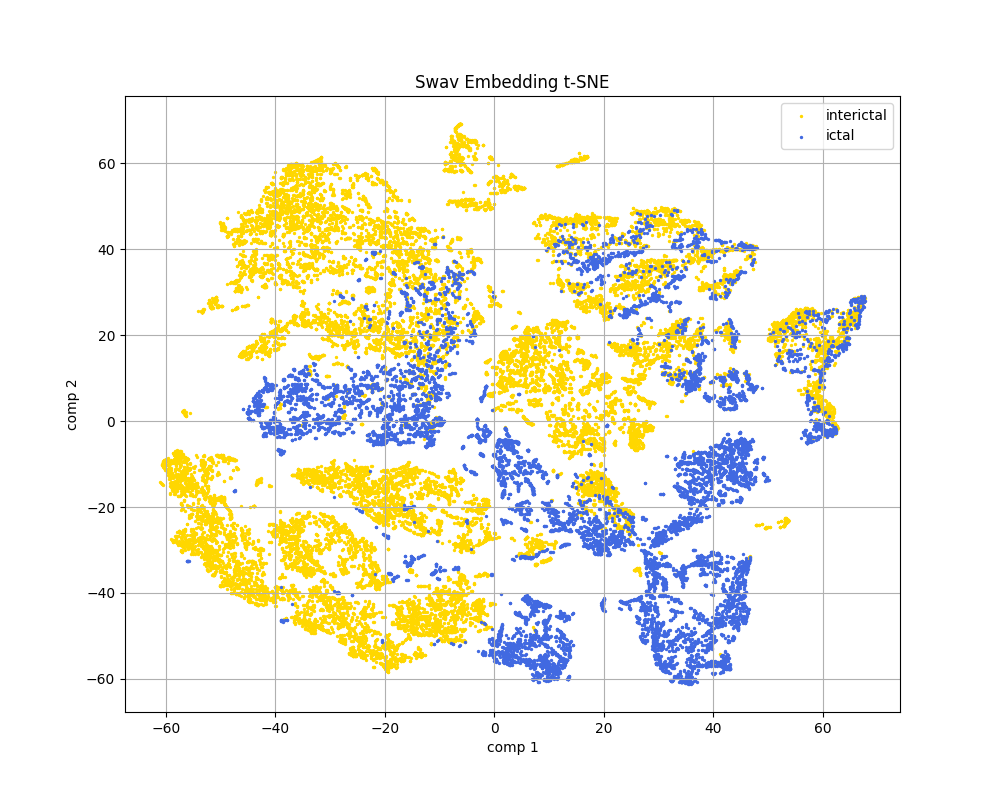

In [50]:
spc = z

plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],2,c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds,0],spc[ictal_inds,1],2,c='royalblue',label= 'ictal')
plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2" )
plt.legend()
# plt.xlim(-67,74)
# plt.ylim(-67,75)
plt.grid()
plt.show()

(36506, 2)
(4,)


<IPython.core.display.Javascript object>


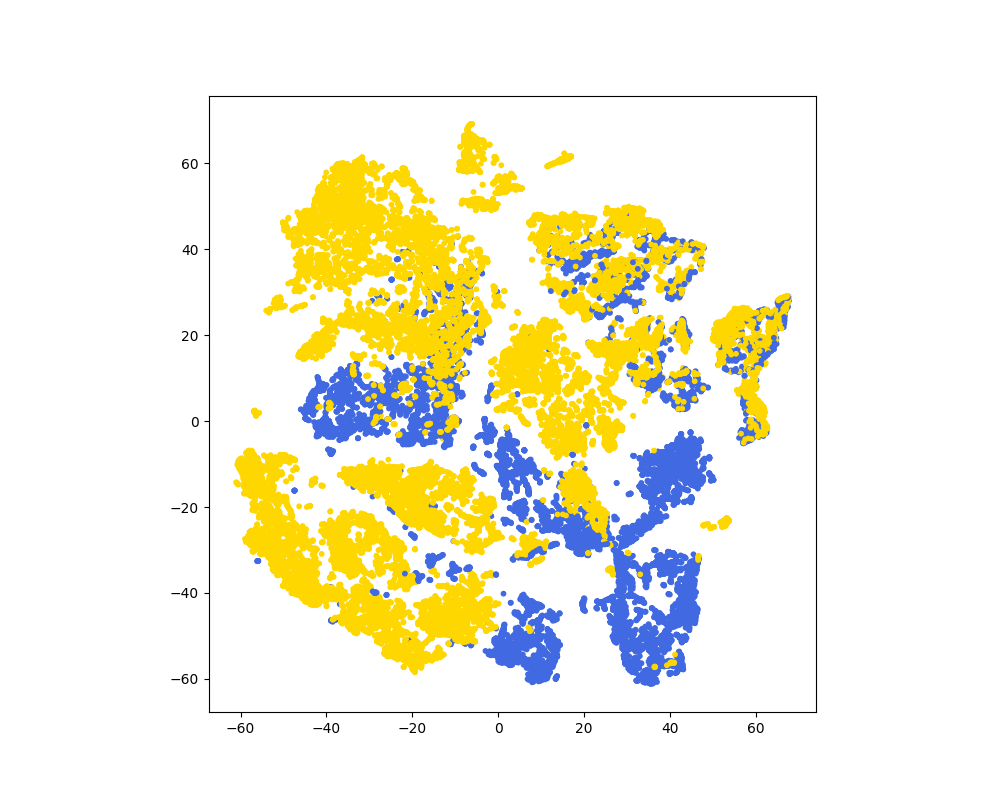

In [46]:
# dt = np.vstack((z[:,0], z[:,1])).T
interactive_plot.interactive_plot(z,['RNS026', 'HUP159', 'HUP129', 'HUP096'],data_import,color_override = target)

In [41]:
interactive_plot.interactive_plot(z,['HUP159'],data_import,color_override = target)

(12790, 2)
(1,)


<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(
    target,
    output[:,1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
output[:,1]

In [ ]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target= target.squeeze().detach().cpu().numpy()

In [ ]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
for batch, label in tqdm(val_dataloader):
        batch = batch.to(device)
        label = label.to(device)
        label = F.one_hot(label).squeeze()
        outputs = model(batch)
        print(batch)
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = 0.5, gamma = 8,reduction = 'mean')
        print(loss)
        break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")